In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter

import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr as scipy_pearsonr

import os

C:\Program Files\Anaconda3\envs\carmi_thesis_3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import importlib
import plot, loaders
plot = importlib.reload(plot)
loaders = importlib.reload(loaders)

In [3]:
PGS_DIR = os.path.join("data", "pgs")
SAVE_FIG_DIR = "suppfigure2"

# Gain conditioned on parents

In [4]:
longevity_data = loaders.load_longevity_data(pgs_col=os.path.join(PGS_DIR, "longevity_height"), convert_to_cm=True)
longevity_data.head()

const  Gender  Age       PGS  Height
FID IID                                      
2   427    1.0       0   61  0.000028  157.48
    448    1.0       1   62  0.000028  177.80
11  615    1.0       0   64  0.000042  157.48
    616    1.0       1   65  0.000086  172.72
24  887    1.0       1   65  0.000106  187.96

In [5]:
height_model_covar = sm.OLS(endog=longevity_data["Height"], exog=longevity_data[["const", "Gender", "Age"]]).fit()
print(height_model_covar.rsquared)
height_model_pgs_res = sm.OLS(endog=height_model_covar.resid, exog=longevity_data[["const", "PGS"]]).fit()
print(height_model_pgs_res.summary())

0.6083835435619124
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     65.49
Date:                Tue, 13 Aug 2019   Prob (F-statistic):           5.18e-14
Time:                        00:43:51   Log-Likelihood:                -635.79
No. Observations:                 206   AIC:                             1276.
Df Residuals:                     204   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6249      0.788 

## ASPIS IQ Model

In [6]:
aspis_data = loaders.load_aspis_data(pgs_col=os.path.join(PGS_DIR, "aspis_gcf"))
aspis_data.head()

const       PGS         IQ
FID IID                            
5   5      1.0  0.000005  95.673167
10  10     1.0 -0.000014  98.480256
11  11     1.0 -0.000012  91.335666
22  22     1.0 -0.000005  87.262629
41  41     1.0 -0.000008  97.917961

In [7]:
iq_model_pgs = sm.OLS(endog=aspis_data["IQ"], exog=aspis_data[["const", "PGS"]]).fit()
print(iq_model_pgs.summary())

                            OLS Regression Results                            
Dep. Variable:                     IQ   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     41.66
Date:                Tue, 13 Aug 2019   Prob (F-statistic):           1.76e-10
Time:                        00:43:56   Log-Likelihood:                -3770.8
No. Observations:                 919   AIC:                             7546.
Df Residuals:                     917   BIC:                             7555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.3033      0.824    126.628      0.0

## Prediction

In [9]:
longevity_so_random_10_height_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_random_10_height"))
longevity_so_actual_10_height_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_actual_10_height"))
longevity_so_random_10_height_pred = height_model_pgs_res.predict(sm.add_constant(longevity_so_random_10_height_pgs))
longevity_so_actual_10_height_pred = height_model_pgs_res.predict(sm.add_constant(longevity_so_actual_10_height_pgs))

pd.concat({"random": longevity_so_random_10_height_pred.sample(3),
           "actual": longevity_so_actual_10_height_pred.sample(3)}, names=["matching"])

matching  FID        IID 
actual    5820_5821  SO07   -0.616872
          2241_2252  SO05    0.147612
          6162_6163  SO09    3.361265
random    5116_5270  SO06    4.342176
          2843_2317  SO06    1.154404
          7150_6040  SO00   -0.700835
dtype: float64

In [10]:
aspis_so_10_gcf_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "aspis_so_random_10_gcf"))
aspis_so_10_iq_pred = iq_model_pgs.predict(sm.add_constant(aspis_so_10_gcf_pgs))
aspis_so_10_iq_pred.head()

FID        IID 
1002_3186  SO00    96.097116
           SO01    94.172263
           SO02    94.364762
           SO03    91.499255
           SO04    98.227435
dtype: float64

## Gain

In [11]:
def calculate_gain(preds):
    preds = preds.groupby(["FID"]).agg(["max", "mean"])
    preds = preds["max"] - preds["mean"]
    return preds

In [12]:
longevity_so_random_10_height_gain = calculate_gain(longevity_so_random_10_height_pred)
longevity_so_actual_10_height_gain = calculate_gain(longevity_so_actual_10_height_pred)
aspis_so_10_iq_gain = calculate_gain(aspis_so_10_iq_pred)

pd.concat({"Longevity_Random": longevity_so_random_10_height_gain.sample(2),
           "Longevity_Actual": longevity_so_actual_10_height_gain.sample(2),
           "ASPIS_Random": aspis_so_10_iq_gain.sample(2)}, names=["set"])

set               FID      
ASPIS_Random      7372_4232    3.065546
                  210_7324     3.681198
Longevity_Actual  3722_3723    3.379870
                  3189_3275    3.219632
Longevity_Random  3689_4594    3.928365
                  1336_3275    3.165272
dtype: float64

### Parents' data

Extract Parents' prediction values

In [13]:
def extract_parents_data(embryos_gain, parents_vals_db):
    parents = embryos_gain.index.to_series().str.split("_", expand=True)
    parents = parents.astype(int)
    parents = parents.applymap(lambda x: parents_vals_db.xs(x, level="IID").iloc[0])
    return parents

def get_data_for_plotting(gain, parents_vals):
    parents = extract_parents_data(gain, parents_vals)
    parents["mean"] = parents.mean(axis="columns")
    data = pd.concat([gain.rename("gain"), parents], axis="columns")
    return data

In [14]:
longevity_so_random_10_plot_data = get_data_for_plotting(longevity_so_random_10_height_gain, height_model_pgs_res.fittedvalues)
longevity_so_actual_10_plot_data = get_data_for_plotting(longevity_so_actual_10_height_gain, height_model_pgs_res.fittedvalues)
aspis_so_10_plot_data = get_data_for_plotting(aspis_so_10_iq_gain, iq_model_pgs.fittedvalues)

plot_data = pd.concat({"longevity_random": longevity_so_random_10_plot_data,
                       "longevity_actual": longevity_so_actual_10_plot_data,
                       "aspis_random": aspis_so_10_plot_data}, 
                      names=["set"])
plot_data.groupby("set", group_keys=False).apply(lambda x: x.head(2))

gain           0           1        mean
set              FID                                                    
aspis_random     1002_3186  2.965291   99.030842   93.424648   96.227745
                 1007_2343  1.770264  101.753427  100.937561  101.345494
longevity_actual 1130_1131  2.184065   -1.520993   -7.927510   -4.724252
                 1235_1236  2.522355   -0.520139   -4.631195   -2.575667
longevity_random 1130_2269  1.241834   -1.520993   -0.356955   -0.938974
                 1130_4594  1.894884   -1.520993    0.200009   -0.660492

## Plot

In [15]:
PLOT_THICKENS = True
if PLOT_THICKENS:
    # sns.plotting_context("talk")
    CUSTOM_SNS_RC = {'xtick.labelsize': 13.5, 'ytick.labelsize': 13.5, 'legend.fontsize': 13.0, 
                                                 'axes.labelsize': 14, 'axes.titlesize': 15}
    # sns.set_context("paper", font_scale=1.4, rc=CUSTOM_SNS_RC)
    sns.set_context("talk", font_scale=1, rc=CUSTOM_SNS_RC)

### Scatter

In [15]:
def single_scatter_plot(plot_data, units, title, x_label, fit_reg=False, abs_x=False, ax=None):
    ax = ax or plt.gca()
    
    y = plot_data["gain"]
    x = plot_data["mean"]
    if abs_x:
        x = x.abs()
    r, p = scipy_pearsonr(x, y)
    label = "r={r:.3f}, p={p:.3f}".format(r=r, p=p)
    
    sns.regplot(x=x, y=y, fit_reg=fit_reg,
                ax=ax, color="C0", line_kws={"label": label})
    if fit_reg:
        y0, y1 = ax.get_ylim()
        ax.set_ylim(y0, y1 + (y1-y0)*0.15)   # Make space for legend
        ax.legend(loc="upper left")
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Gain [{}]".format(units))
    ax.yaxis.set_tick_params(pad=2)
    ax.xaxis.set_tick_params(pad=2)
    return ax

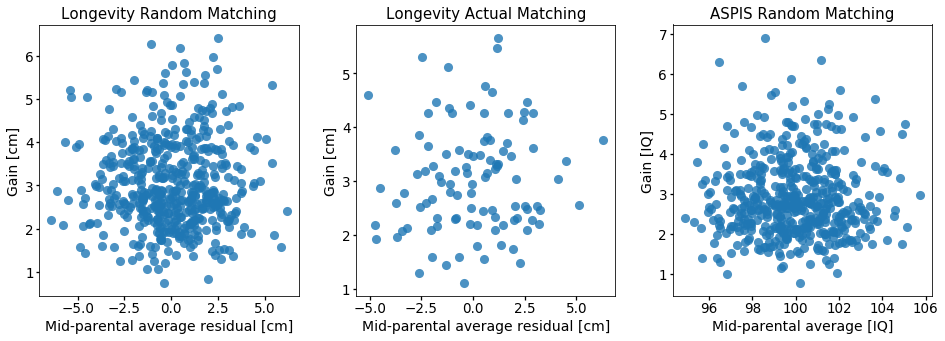

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)
fit_reg = False


single_scatter_plot(plot_data.xs("longevity_random"), "cm", title="Longevity Random Matching",
                    ax=axes[0], fit_reg=fit_reg, x_label="Mid-parental average residual [cm]")
single_scatter_plot(plot_data.xs("longevity_actual"), "cm", title="Longevity Actual Matching",
                    ax=axes[1], fit_reg=fit_reg, x_label="Mid-parental average residual [cm]")
single_scatter_plot(plot_data.xs("aspis_random"), "IQ", title="ASPIS Random Matching",
                    ax=axes[2], fit_reg=fit_reg, x_label="Mid-parental average [IQ]")
fig.subplots_adjust(wspace=0.22)

In [409]:
plot.save_fig(fig, "gain-by-avg-parents_scatter" + ("_reg" if fit_reg else ""),
              SAVE_FIG_DIR)

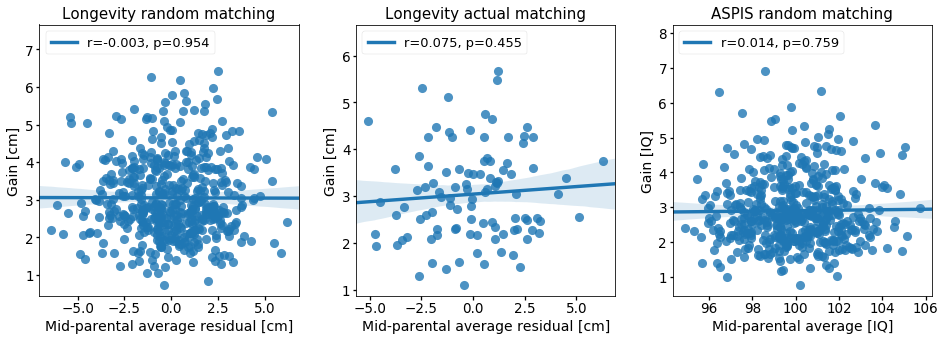

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)
fit_reg = True


single_scatter_plot(plot_data.xs("longevity_random"), "cm", title="Longevity random matching",
                    ax=axes[0], fit_reg=fit_reg, x_label="Mid-parental average residual [cm]")
single_scatter_plot(plot_data.xs("longevity_actual"), "cm", title="Longevity actual matching",
                    ax=axes[1], fit_reg=fit_reg, x_label="Mid-parental average residual [cm]")
single_scatter_plot(plot_data.xs("aspis_random"), "IQ", title="ASPIS random matching",
                    ax=axes[2], fit_reg=fit_reg, x_label="Mid-parental average [IQ]")
fig.subplots_adjust(wspace=0.22)

In [19]:
plot.save_fig(fig, "gain-by-avg-parents_scatter" + ("_reg" if fit_reg else ""),
              SAVE_FIG_DIR)

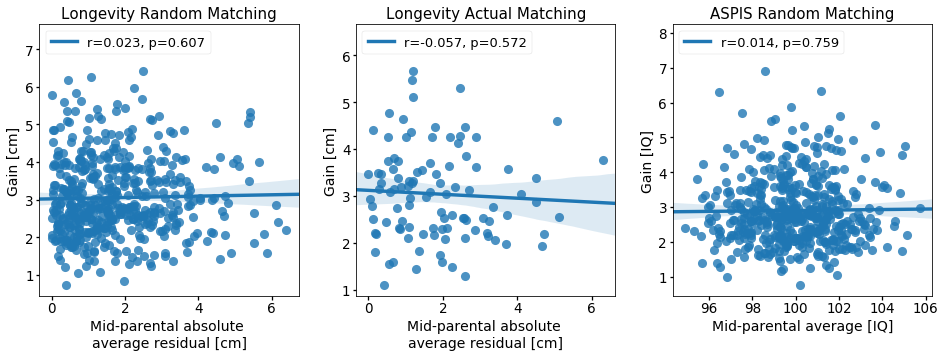

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)
fit_reg = True


single_scatter_plot(plot_data.xs("longevity_random"), "cm", title="Longevity Random Matching", abs_x=True,
                    ax=axes[0], fit_reg=fit_reg, x_label="Mid-parental absolute \naverage residual [cm]")
single_scatter_plot(plot_data.xs("longevity_actual"), "cm", title="Longevity Actual Matching", abs_x=True,
                    ax=axes[1], fit_reg=fit_reg, x_label="Mid-parental absolute \naverage residual [cm]")
single_scatter_plot(plot_data.xs("aspis_random"), "IQ", title="ASPIS Random Matching", 
                    ax=axes[2], fit_reg=fit_reg, x_label="Mid-parental average [IQ]")
fig.subplots_adjust(wspace=0.22)

In [415]:
plot.save_fig(fig, "gain-by-abs-avg-parents_scatter" + ("_reg" if fit_reg else ""),
              SAVE_FIG_DIR)

## Use parents' true residuals, not fitted

In [16]:
longevity_so_random_10_plot_data = get_data_for_plotting(longevity_so_random_10_height_gain, 
                                                         height_model_pgs_res.model.data.orig_endog)
longevity_so_actual_10_plot_data = get_data_for_plotting(longevity_so_actual_10_height_gain, 
                                                         height_model_pgs_res.model.data.orig_endog)
aspis_so_10_plot_data = get_data_for_plotting(aspis_so_10_iq_gain, iq_model_pgs.model.data.orig_endog)

plot_data = pd.concat({"longevity_random": longevity_so_random_10_plot_data,
                       "longevity_actual": longevity_so_actual_10_plot_data,
                       "aspis_random": aspis_so_10_plot_data}, 
                      names=["set"])
plot_data.groupby("set", group_keys=False).apply(lambda x: x.head(2))

gain          0          1       mean
set              FID                                                 
aspis_random     1002_3186  2.965291  98.818648  80.997998  89.908323
                 1007_2343  1.770264  90.363771  61.771930  76.067850
longevity_actual 1130_1131  2.184065  -3.726650 -10.011626  -6.869138
                 1235_1236  2.522355  -4.879513  -4.892424  -4.885969
longevity_random 1130_2269  1.241834  -3.726650  -6.849537  -5.288093
                 1130_4594  1.894884  -3.726650   7.785745   2.029548

## Plot

In [17]:
PLOT_THICKENS = True
if PLOT_THICKENS:
    # sns.plotting_context("talk")
    CUSTOM_SNS_RC = {'xtick.labelsize': 13.5, 'ytick.labelsize': 13.5, 'legend.fontsize': 13.0, 
                                                 'axes.labelsize': 14, 'axes.titlesize': 15}
    # sns.set_context("paper", font_scale=1.4, rc=CUSTOM_SNS_RC)
    sns.set_context("talk", font_scale=1, rc=CUSTOM_SNS_RC)

### Scatter

In [18]:
def single_scatter_plot(plot_data, units, title, x_label, fit_reg=False, abs_x=False, ax=None):
    ax = ax or plt.gca()
    
    y = plot_data["gain"]
    x = plot_data["mean"]
    if abs_x:
        x = x.abs()
    r, p = scipy_pearsonr(x, y)
    label = "r={r:.3f}, p={p:.3f}".format(r=r, p=p)
    
    sns.regplot(x=x, y=y, fit_reg=fit_reg,
                ax=ax, color="C0", line_kws={"label": label})
    if fit_reg:
        y0, y1 = ax.get_ylim()
        ax.set_ylim(y0, y1 + (y1-y0)*0.15)   # Make space for legend
        ax.legend(loc="upper left")
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Gain [{}]".format(units))
    ax.yaxis.set_tick_params(pad=2)
    ax.xaxis.set_tick_params(pad=2)
    return ax

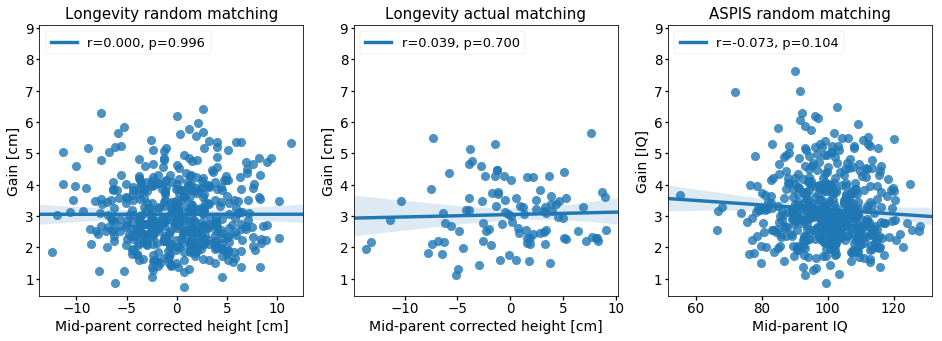

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)
fit_reg = True
SHAREY = True


single_scatter_plot(plot_data.xs("longevity_random"), "cm", title="Longevity random matching",
                    ax=axes[0], fit_reg=fit_reg, x_label="Mid-parent corrected height [cm]")
single_scatter_plot(plot_data.xs("longevity_actual"), "cm", title="Longevity actual matching",
                    ax=axes[1], fit_reg=fit_reg, x_label="Mid-parent corrected height [cm]")
single_scatter_plot(plot_data.xs("aspis_random"), "IQ", title="ASPIS random matching",
                    ax=axes[2], fit_reg=fit_reg, x_label="Mid-parent IQ")
if SHAREY:
    max_ylim = max([ax.get_ylim()[1] for ax in axes])
    min_ylim = min([ax.get_ylim()[0] for ax in axes])
    [ax.set_ylim(min_ylim, max_ylim) for ax in axes]
fig.subplots_adjust(wspace=0.19)

In [24]:
plot.save_fig(fig, "gain-by-avg-parents-tresid_scatter" + ("_reg" if fit_reg else "") + ("_sharey" if SHAREY else ""),
              SAVE_FIG_DIR)

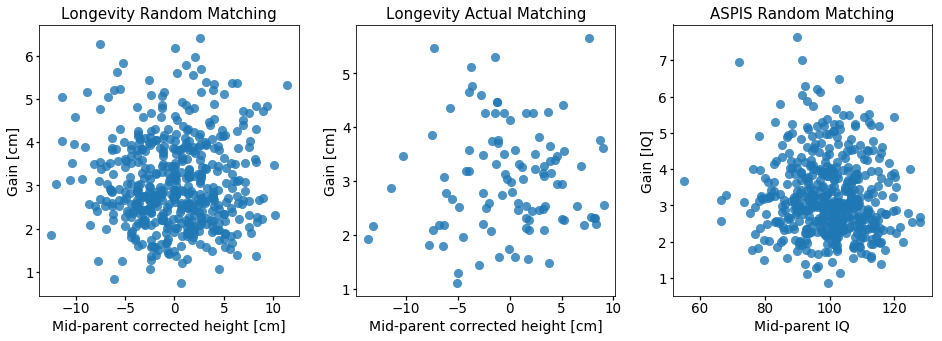

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)
fit_reg = False


single_scatter_plot(plot_data.xs("longevity_random"), "cm", title="Longevity Random Matching",
                    ax=axes[0], fit_reg=fit_reg, x_label="Mid-parent corrected height [cm]")
single_scatter_plot(plot_data.xs("longevity_actual"), "cm", title="Longevity Actual Matching",
                    ax=axes[1], fit_reg=fit_reg, x_label="Mid-parent corrected height [cm]")
single_scatter_plot(plot_data.xs("aspis_random"), "IQ", title="ASPIS Random Matching",
                    ax=axes[2], fit_reg=fit_reg, x_label="Mid-parent IQ")
fig.subplots_adjust(wspace=0.22)

In [431]:
plot.save_fig(fig, "gain-by-avg-parents-tresid_scatter" + ("_reg" if fit_reg else ""),
              SAVE_FIG_DIR)

## Use parents' predictions

In [19]:
longevity_so_random_10_plot_data = get_data_for_plotting(longevity_so_random_10_height_gain, 
                                                         height_model_pgs_res.fittedvalues)
longevity_so_actual_10_plot_data = get_data_for_plotting(longevity_so_actual_10_height_gain, 
                                                         height_model_pgs_res.fittedvalues)
aspis_so_10_plot_data = get_data_for_plotting(aspis_so_10_iq_gain, iq_model_pgs.fittedvalues)

plot_data = pd.concat({"longevity_random": longevity_so_random_10_plot_data,
                       "longevity_actual": longevity_so_actual_10_plot_data,
                       "aspis_random": aspis_so_10_plot_data}, 
                      names=["set"])
plot_data.groupby("set", group_keys=False).apply(lambda x: x.head(2))

gain           0           1        mean
set              FID                                                    
aspis_random     1002_3186  2.965291   99.030842   93.424648   96.227745
                 1007_2343  1.770264  101.753427  100.937561  101.345494
longevity_actual 1130_1131  2.184065   -1.520993   -7.927510   -4.724252
                 1235_1236  2.522355   -0.520139   -4.631195   -2.575667
longevity_random 1130_2269  1.241834   -1.520993   -0.356955   -0.938974
                 1130_4594  1.894884   -1.520993    0.200009   -0.660492

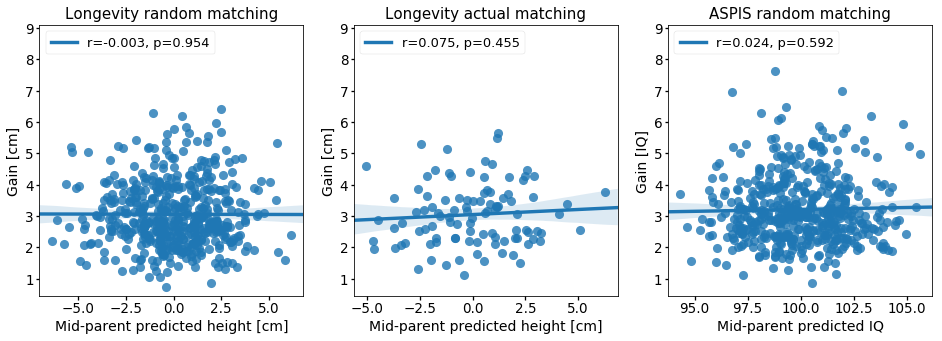

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)
fit_reg = True
SHAREY = True


single_scatter_plot(plot_data.xs("longevity_random"), "cm", title="Longevity random matching",
                    ax=axes[0], fit_reg=fit_reg, x_label="Mid-parent predicted height [cm]")
single_scatter_plot(plot_data.xs("longevity_actual"), "cm", title="Longevity actual matching",
                    ax=axes[1], fit_reg=fit_reg, x_label="Mid-parent predicted height [cm]")
single_scatter_plot(plot_data.xs("aspis_random"), "IQ", title="ASPIS random matching",
                    ax=axes[2], fit_reg=fit_reg, x_label="Mid-parent predicted IQ")
if SHAREY:
    max_ylim = max([ax.get_ylim()[1] for ax in axes])
    min_ylim = min([ax.get_ylim()[0] for ax in axes])
    [ax.set_ylim(min_ylim, max_ylim) for ax in axes]
fig.subplots_adjust(wspace=0.19)

In [21]:
plot.save_fig(fig, "gain-by-avg-parents-predict_scatter" + ("_reg" if fit_reg else "") + ("_sharey" if SHAREY else ""),
              SAVE_FIG_DIR)